# Problem 1.1.1

In [70]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image
import cv2
import math
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset
import os

def parse_file(fp):    
    """ Extract ground-truth boxes from XML file. """
    # extract xml tree
    tree = ET.parse(fp)
    root = tree.getroot()

    # identify objects
    # extract boundary box data
    output = []
    for obj in root.findall("./object"):
        name = obj.find("name").text
        box = obj.find("bndbox")
        x = int(box.find("xmin").text)
        xmax = int(box.find("xmax").text)
        y = int(box.find("ymin").text)
        ymax = int(box.find("ymax").text)
        
        x_center = (xmax + x)/2
        y_center = (ymax + y)/2
        w = xmax - x
        h = ymax - y
        
        coords = [name, x_center, y_center, w, h]
        output.append(coords)

    # put in numpy array format 
    output = np.array(output)
    
    return(output)

# Problem 1.1.2

In [71]:
def show_image(img_path, xml_path):
    """ Display image with ground-truth boxes. """
    # load image
    # load xml file
    img = Image.open(img_path)
    bndbox = parse_file(xml_path)
    
    # make figure
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    # make boxes
    for obj in bndbox:
        box = patches.Rectangle((int(obj[1]), int(obj[2])), int(obj[3]), int(obj[4]), 
                                linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(box)

# Problem 1.3

In [72]:
# coordinate conversion functions
def to_minmax(x_center, y_center, w, h):
    """ Convert center coordinates to min/max. """
    x_min = x_center - 0.5 * w
    y_min = y_center - 0.5 * h
    x_max = x_center + 0.5 * w
    y_max = y_center + 0.5 * h
    return x_min, x_max, y_min, y_max

def to_center(x_min, x_max, y_min, y_max):
    """ Convert min/max coordinates to center. """
    h = y_max - y_min
    w = x_max - x_min    
    x_center = x_min + 0.5 * w
    y_center = y_min + 0.5 * h
    return x_center, y_center, w, h

def rescale(x_scale_orig, y_scale_orig, x_scale_new, y_scale_new, x_min, x_max, y_min, y_max):
    """ Adjust ground-truth box sizes. """ 
    x_ratio = x_scale_new / x_scale_orig
    y_ratio = y_scale_new / y_scale_orig
    x_min_new = round(x_min * x_ratio)
    x_max_new = round(x_max * x_ratio)
    y_min_new = round(y_min * y_ratio)
    y_max_new = round(y_max * y_ratio)
    
    return x_min_new, x_max_new, y_min_new, y_max_new

In [73]:
# metric calculation functions

def get_offset(box_prop, box_true):
    """ Calculate offset between two boxes. """
    d_xmin = box_true[0] - box_prop[0]
    d_xmax = box_true[1] - box_prop[1]
    d_ymin = box_true[2] - box_prop[2]
    d_ymax = box_true[3] - box_prop[3]
    
    (dx, dy, dw, dh) = to_center(d_xmin, d_xmax, d_ymin, d_ymax)
    
    return dx, dy, dw, dh

def get_IOU(box1, box2):
    """
    Compute overlap (IOU) between box1 and box2.
    Credit to the RPN notebook we were given.
    """
    
    # ------calculate coordinate of overlapping region------
    # take max of x1 and y1 out of both boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[2], box2[2])
    
    # take min of x2 and y2 out of both boxes
    x2 = min(box1[1], box2[1])
    y2 = min(box1[3], box2[3])
    
    # check if they atleast overlap a little
    if (x1 < x2 and y1 < y2):
        # ------area of overlapping region------
        width_overlap = (x2 - x1)
        height_overlap = (y2 - y1)
        area_overlap = width_overlap * height_overlap
    else:
        # there is no overlap
        return 0
    
    # ------computing union------
    # sum of area of both the boxes - area_overlap
    
    # height and width of both boxes
    width_box1 = (box1[1] - box1[0])
    height_box1 = (box1[3] - box1[2])
    
    width_box2 = (box2[1] - box2[0])
    height_box2 = (box2[3] - box2[2])
    
    # area of box1 and box2
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    
    # union (including 2 * overlap area (double count))
    area_union_overlap = area_box1 + area_box2
    
    # union
    area_union = area_union_overlap - area_overlap
    
    # compute IOU
    iou = area_overlap/ area_union
    
    return iou

In [75]:
### generate proposed boxes ### 

def gen_box_proposals(w_stride=2, h_stride=2, img_width=64, img_height=64):
    """ Generate proposed boxes. """
    # generate anchor points
    xs = np.arange(w_stride, img_width, w_stride)
    ys = np.arange(h_stride, img_height, h_stride)
    anchors = np.array(np.meshgrid(xs, ys,  sparse=False, indexing='xy')).T.reshape(-1,2)

    # generate list of proposed boxes ([anchor points] x [scales] x [aspect ratios])
    base_scale = 5 # distance from center to edge
    scales = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    ratios = [1, 1/4, 1/3, 1/2, 2/3, 3/4, 2, 5/4, 4/3, 3/2, 5/3, 7/4, 3] # r = w / h
    box_props = []
    for anchor in anchors:
        for scale in scales:
            for ratio in ratios:
                if ratio <= 1:
                    box_prop = [anchor[0], anchor[1], round(base_scale * scale), round(base_scale * scale / ratio)]
                else:
                    box_prop = [anchor[0], anchor[1], round(base_scale * scale * ratio), round(base_scale * scale)]
                box_prop_adj = to_minmax(*box_prop)
                box_props.append(box_prop_adj)
    box_props = np.array(box_props)

    # subset proposed boxes to be entirely in frame
    box_props = box_props[np.all((box_props >= 1) & (box_props <= 64), axis=1)]
    return box_props

In [75]:
### extract images + ground-truth boxes ###

def extract_data(img_path, box_props):
    # figure out img, xml filepaths
    xml_base = "data/VOCdevkit/VOC2012/Annotations/"
    file_id = os.path.splitext(os.path.basename(img_path))[0]
    xml_path = xml_base + file_id + ".xml"
    
    
    ### Images ###
    # preprocess images
    img_orig = np.array(Image.open(img_path))
    img = cv2.resize(img_orig, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    img = torch.Tensor(img).unsqueeze(0)
    img = img.permute(0,3,1,2)
    
    
    ### Ground-truth boxes ###
    # load ground truth boxes
    # extract boxes from xml
    bndbox = parse_file(xml_path)[:,1:].astype(float)

    # convert from center to minmax
    bndbox = [to_minmax(*row) for row in bndbox]

    # adjust scale of ground truth boxes to match scaled-down image
    bndbox_adj = []
    for box in bndbox:
        (xmin, xmax, ymin, ymax) = rescale(img_orig.shape[0], img_orig.shape[1], 64, 64, box[0], box[1], box[2], box[3])
        bndbox_adj.append([xmin, xmax, ymin, ymax])
    bndbox_adj = np.array(bndbox_adj)
    
    
    ### Offsets + Labels ###
    offsets = []
    labels = []
    for box_prop in box_props:
        # identify most relevant ground-truth box
        i = -1
        max_iou = -1
        for box_true in bndbox_adj:
            i += 1
            iou = get_IOU(box_prop, box_true)
            if iou > max_iou:
                max_iou = iou
                max_i = i
        best_box = bndbox_adj[max_i,:]

        # generate offsets
        offset = get_offset(box_prop, best_box)

        # calculate IOU for each box
        # generate labels for each box
        if get_IOU(box_prop, best_box) > 0.7:
            lab = 1
        elif get_IOU(box_prop, best_box) < 0.3:
            lab = 0
        else: 
            lab = -1  

        offsets.append(list(offset))
        labels.append(lab)

    offsets = torch.Tensor(offsets).unsqueeze(0)
    labels = torch.Tensor(labels).unsqueeze(0)
    
    
    return img, bndbox_adj, offsets, labels

In [75]:
# set up loop
first_flag = True
bndboxes = []
img_base = "data/VOCdevkit/VOC2012/JPEGImages/"
img_paths = os.listdir(img_base)

# generate proposed boxes
print("Generating box proposals...")
box_props = gen_box_proposals()

# loop through images + xmls, extract data
print("Extracting data...")
i = 1
for img_path in img_paths:
    print(f"(File {i} of {len(img_paths)})", end="\r")
    img_path = img_base + img_path
    img, bndbox, offset, label = extract_data(img_path, box_props)
    
    if first_flag:
        imgs = img
        offsets = offset
        labels = label
        first_flag = False
    else:
        imgs = torch.cat((imgs, img), dim=0)
        offsets = torch.cat((offsets, offset), dim=0)
        labels = torch.cat((labels, label), dim=0)
    bndboxes.append(bndbox)
    
    # save data to files (in case of a crash)
    if (i > 1) & (i % 100 == 0):
        torch.save(imgs, "p1_imgs.pt")
        torch.save(offsets, "p1_offsets.pt")
        torch.save(labels, "p1_labels.pt")
    
    i += 1

# save data to files
print("Saving files...")
torch.save(imgs, "p1_imgs.pt")
torch.save(offsets, "p1_offsets.pt")
torch.save(labels, "p1_labels.pt")

print("Data extracted!")

# Problem 2

In [12]:
print("Loading libraries...")
from imagecorruptions import corrupt, get_corruption_names
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
from time import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# setup
print("Setting up images filepaths...")
corr_names = get_corruption_names()
folder_path = "data/VOCdevkit/VOC2012/JPEGImages/"

img_paths = [os.path.join(folder_path, img_path) for img_path in os.listdir(folder_path)]
random.shuffle(img_paths)
partition = int(0.8 * len(img_paths))
train_paths = img_paths[:partition]
val_paths = img_paths[partition:]

print("Defining corruption function...")
# generate corrupted datasets
def corrupt_set(img_paths):
    start = time()
    imgs_final = []
    i = 1
    for img_path in img_paths:
        print(f"Corrupting image {i} of {len(img_paths)}...", end="\r")
        # load image
        # resize image
        img = np.array(Image.open(img_path))
        img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)

        # generate corruptions
        # add to larger dataset
        #for corr_name in corr_names:
        sev = 1
        img_noised = corrupt(img, corruption_name="gaussian_noise", severity=sev)
        img_pair = np.stack([img_noised, img], axis=3)
        imgs_final.append(img_pair)
        i += 1
    # print(time() - start)
    return(imgs_final)

print("Corrupting images...")
train_final = corrupt_set(train_paths)
val_final = corrupt_set(val_paths)

# save dataset
np.save("train_imgs.npy", train_final)
np.save("val_imgs.npy", val_final)
print("Images saved!")

Loading libraries...
Setting up images filepaths...
Defining corruption function...
Corrupting images...
Images saved!age 3425 of 3425.....


In [13]:
# define image data class

class ImgData:
    def __init__(self, fp):
        # load dataset
        # reshape dataset
        data = np.load(fp).transpose(0,3,1,2,4)
        
        # split into corrupted, original images
        # convert to pytorch tensors
        self.corrupted = torch.from_numpy(data[:,:,:,:,0]).to(torch.float32)
        self.orig = torch.from_numpy(data[:,:,:,:,1]).to(torch.float32)
        
    def __len__(self):
        return len(self.corrupted)

    def __getitem__(self, rownum):
        corrupted = self.corrupted[rownum, :, :, :]
        orig = self.orig[rownum, :, :, :]
        return corrupted, orig
    

In [41]:
# define autoencoder model class

class CorruptioNet(nn.Module):
    def __init__(self):
        super(CorruptioNet, self).__init__()
        
        self.Encoder = nn.Sequential(
            nn.Conv2d(3, 32*3, 5, stride=1, padding=2),
            nn.BatchNorm2d(32*3),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(32*3, 16*3, 5, stride=1, padding=2),
            nn.BatchNorm2d(16*3),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )
        
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(16*3, 8*3, 5, stride=1, padding=2),
            nn.BatchNorm2d(8*3),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(8*3, 3, 5, stride=1, padding=2),
            nn.BatchNorm2d(3),
            nn.Sigmoid(),
            nn.Dropout(0.2)
        )
        
        self.c1 = nn.ConvTranspose2d(3, 3, 5, stride=1, padding=2)
        self.a1 = nn.Sigmoid()
        self.bn1 = nn.BatchNorm2d(3)
        self.d1 = nn.Dropout(0.2)
        
    def Decoder2(self, x, x_old):
        x = self.c1(x + x_old)
        x = self.bn1(x)
        x = self.d1(x)
        x = self.a1(x)
        return(x)
    
    def forward(self, x):
        x_old = x
        x = self.Encoder(x)
        x = self.Decoder(x)
        x = self.Decoder2(x, x_old)
        x = torch.round(x * 255) # rescaling to RGB range
        
        return x

In [42]:
val = ImgData("val_imgs.npy")
val_loader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=1)
_, (corr, _) = next(enumerate(val_loader))
model = CorruptioNet()
print(corr.shape)
print(model.Encoder(corr).shape)
out = model(corr)
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 48, 64, 64])
torch.Size([1, 3, 64, 64])


In [43]:
# define training function

def train_model(model, data, val_data, epoch):
    start = time()
    
    # define loss function
    # set optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    
    model = model.to(device)

    # set up data loader
    N_train = 32
    train_loader = torch.utils.data.DataLoader(data, shuffle=True, batch_size=N_train)
    val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=64)
    
    # run training loop
    losses = []
    val_losses = []
    min_loss = 0
    i = 0
    stop_flag = False
    for batch_id, (corrupted, orig) in enumerate(train_loader):
        corrupted = corrupted.to(device)
        orig = orig.to(device)

        # training loss + gradient descent
        print(f"""Batch {batch_id}/{len(train_loader)}""", end="\r")
        model.train()
        optimizer.zero_grad()
        out_image = model(corrupted)
        loss = criterion(orig, out_image)
        loss.backward()
        optimizer.step()
        losses.append([epoch, batch_id, loss.item()/N_train])

        # validation loss
        model.eval()
        val_loss = 0
        N = 0
        with torch.no_grad():
            for _, (corr, orig2) in enumerate(val_loader):
                corr = corr.to(device)
                orig2 = orig2.to(device)

                N_batch = corr.size(0)
                N += N_batch
                denoised = model(corr)
                loss = criterion(denoised, orig2)
                val_loss += loss.item()
                break
        val_loss = val_loss/N
        val_losses.append([epoch, batch_id, val_loss])

        # save models periodically
        if i % 50 == 0:
            old_model = model
            
            # early stopping
            if i > 5:
                recent_loss = np.mean(np.array(val_losses)[-50:-1,2])
                if min_loss == 0:
                    min_loss = recent_loss
                elif recent_loss < min_loss:
                    min_loss = recent_loss
                elif recent_loss > min_loss:
                    stop_flag = True
                    return old_model, losses, val_losses, stop_flag
        
        i += 1

    print(time() - start)
    return model, losses, val_losses, stop_flag

Epoch 1 of 5


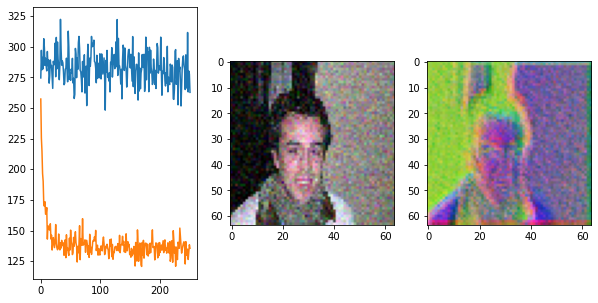

Training complete!


In [44]:
epochs = 5
batch_path = "training_data"
train_batches = [os.path.join(batch_path, data_path) for data_path in os.listdir(batch_path)]
# train_batches = ["train_imgs.npy"]

# loop through training data
# train models

model = CorruptioNet()
#model.load_state_dict(torch.load('autoencoder64.pth'))
#print("Model loaded!")

val = ImgData("val_imgs.npy")
val_loader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=1)
i = 1
for epoch in range(1, epochs+1):
    batch = ImgData("train_imgs.npy")
    if i > 1:
        model.load_state_dict(torch.load('autoencoder64.pth'))

    print(f"Epoch {epoch} of {epochs}")
    model, losses, val_losses, stop_flag = train_model(model, batch, val, epoch)
    torch.save(model.state_dict(), 'autoencoder64.pth')

    losses = np.array(losses)
    val_losses = np.array(val_losses)
    if i == 1:
        loss_combo = np.hstack((losses, val_losses[:,2].reshape(-1, 1)))
        loss = np.array(loss_combo)
    else:
        losses[:,1] = losses[:,1] + max(loss[:,1]) + 1
        loss_combo = np.hstack((losses, val_losses[:,2].reshape(-1, 1)))
        loss = np.concatenate([loss, loss_combo])

    # show test image
    fig, ax = plt.subplots(1,3,figsize=(10,5))
    ax[0].plot(loss[:,1], loss[:,2], marker='', label="training")
    ax[0].plot(loss[:,1], loss[:,3], marker='', label="validation")

    _, (img, _) = next(enumerate(val_loader))
    img_denoised = model(img)
    img = img.permute(0,2,3,1).int()
    img_denoised = img_denoised.permute(0,2,3,1).int()
    ax[1].imshow(img[0,:,:,:].detach().numpy())
    ax[2].imshow(img_denoised[0,:,:,:].detach().numpy())
    plt.show()
    
    if stop_flag:
        break

print("Training complete!")

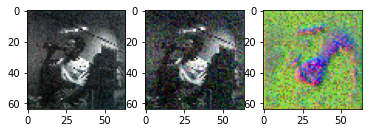

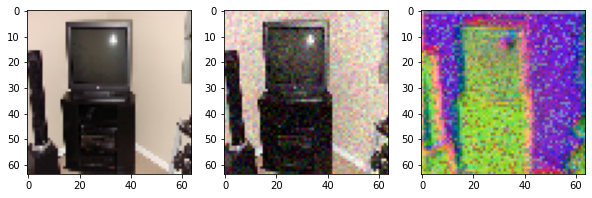

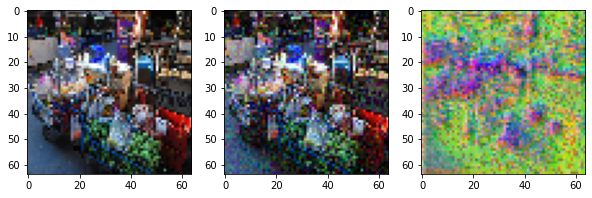

In [68]:
# batch_path = "val_data"
# train_batches = [os.path.join(batch_path, data_path) for data_path in os.listdir(batch_path)]
train_batches = ["val_imgs.npy"]
model = CorruptioNet()
model.load_state_dict(torch.load('autoencoder64.pth'))
val = ImgData(train_batches[0])
val_loader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=32)

_, (img_noised, img) = next(enumerate(val_loader))
img_new = model(img_noised)

img = img.permute(0,2,3,1).int()
img_noised = img_noised.permute(0,2,3,1).int()
img_new = img_new.permute(0,2,3,1).int()

fig, ax = plt.subplots(1,3)
ax[0].imshow(img[0,:,:,:].detach().numpy())
ax[1].imshow(img_noised[0,:,:,:].numpy())
ax[2].imshow(img_new[0,:,:,:].detach().numpy())

fig, ax = plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(img[1,:,:,:].detach().numpy())
ax[1].imshow(img_noised[1,:,:,:].numpy())
ax[2].imshow(img_new[1,:,:,:].detach().numpy())

fig, ax = plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(img[2,:,:,:].detach().numpy())
ax[1].imshow(img_noised[2,:,:,:].numpy())
ax[2].imshow(img_new[2,:,:,:].detach().numpy())

In [ ]:
print(len(train_batches))